In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import h3
from shapely.geometry import shape, Polygon
import shapely
import folium
import json


In [3]:
trips = pd.read_parquet('../00_data/processed/trips.parquet')
trips_g =pd.read_parquet('../00_data/processed/trips_grouped_spatio_temporal.parquet')
weather = pd.read_parquet('../00_data/repo_data/weather_aggr.parquet')
relocations = pd.read_parquet('../00_data/processed/relocations.parquet')
landuse = pd.read_parquet('../00_data/repo_data/hexagons_land_use_columns.parquet')
tripuse = pd.read_parquet('../00_data/repo_data/trips_land_use.parquet')
pois = pd.read_parquet('../00_data/processed/hexagons_with_pois.parquet')
file = "../00_data/repo_data/DE008L2_LEIPZIG_UA2018_v013/Data/DE008L2_LEIPZIG_UA2018_v013.gpkg"
land_usepolys = gpd.read_file(file)

In [4]:

trips['datetime_h'] = trips['datetime_start'].dt.round('H')


In [5]:
tripweather = pd.merge(trips, weather, how='left', left_on ='datetime_h', right_on= 'MESS_DATUM')


In [6]:
tripweather["mintemp_r"] = tripweather["min_temperature"].round(1)
tripweather["meantemp_r"] = tripweather["mean_temperature"].round(1)
tripweather["maxtemp_r"] = tripweather["max_temperature"].round(1)

,count,metric,temp %,cleaned_count
temperature °C,,,,
-10.4,12,min_temp,0.000267,44895.0
-10.2,4,min_temp,0.000134,29930.0
-10.1,3,min_temp,0.000067,44895.0
-9.7,8,min_temp,0.000134,59860.0
-9.4,4,min_temp,0.000067,59860.0
...,...,...,...,...
36.2,239,max_temp,0.000134,1788317.5
36.4,123,max_temp,0.000067,1840695.0
37.0,113,max_temp,0.000067,1691045.0


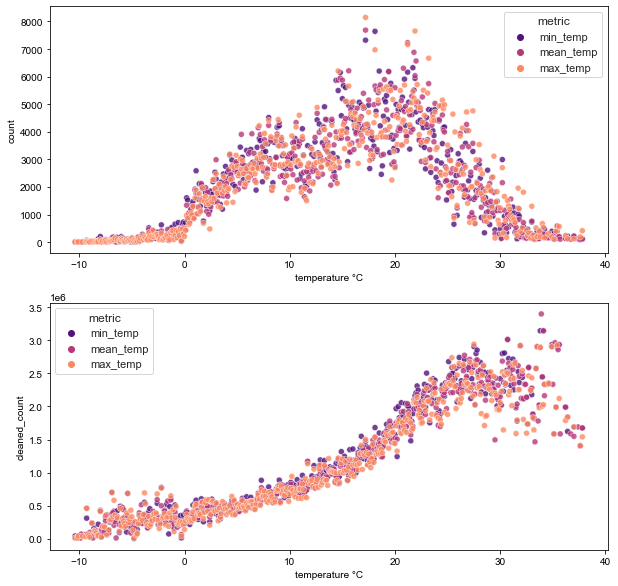

In [7]:
f,ax = plt.subplots(2,1,figsize=(10,10))
sns.set(style="whitegrid")
meanperc = (weather["mean_temperature"].round(1).value_counts()/weather["mean_temperature"].size).rename("temp %")
minperc = (weather["min_temperature"].round(1).value_counts()/weather["min_temperature"].size).rename("temp %")
maxperc = (weather["max_temperature"].round(1).value_counts()/weather["max_temperature"].size).rename("temp %")
y1 = tripweather.groupby(['mintemp_r']).size().to_frame("count")
y1["metric"] = "min_temp"
y1 = y1.merge(minperc, left_index=True, right_index=True)
y2 = tripweather.groupby(['meantemp_r']).size().to_frame("count")
y2["metric"] = "mean_temp"
y2 = y2.merge(meanperc, left_index=True, right_index=True)    
y3 = tripweather.groupby(['maxtemp_r']).size().to_frame("count")
y3["metric"] = "max_temp"
y3 = y3.merge(maxperc, left_index=True, right_index=True)
y_all = pd.concat([y1, y2, y3])
y_all.index.rename("temperature °C", inplace=True)
y_all["cleaned_count"] = y_all["count"]/y_all["temp %"]
sns.scatterplot(data = y_all, x = y_all.index, y ="count", hue ="metric", palette = "magma", alpha = 0.8, ax = ax[0])
sns.scatterplot(data = y_all, x = y_all.index, y ="cleaned_count", hue ="metric", palette = "magma", alpha = 0.8, ax = ax[1])
weather["mean_temperature"].mean()
y_all


2.378829908675799

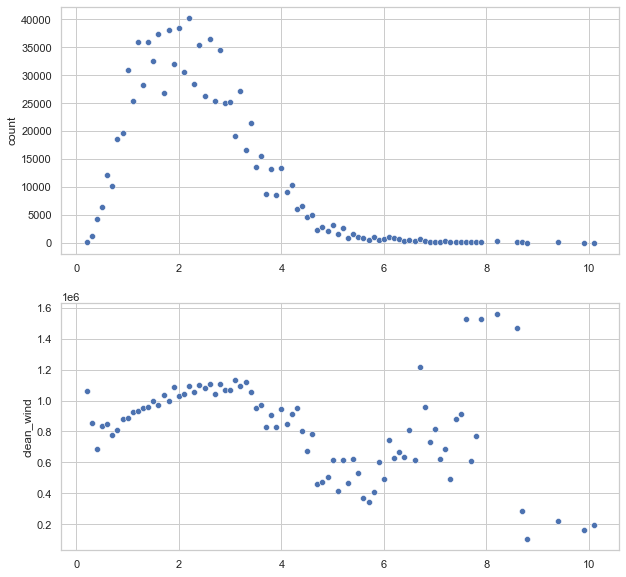

In [8]:
f, ax = plt.subplots(2,1, figsize=(10, 10))
tripweather["mean_mean_wind_speed_r"] = tripweather["mean_mean_wind_speed"].round(1)
y = tripweather.groupby(['mean_mean_wind_speed_r']).size().to_frame("count")
windperc = (weather["mean_mean_wind_speed"].round(1).value_counts()/weather["mean_mean_wind_speed"].size).rename("wind %")
y = y.merge(windperc, left_index=True, right_index=True)
y["clean_wind"] = y["count"]/y["wind %"]
sns.scatterplot(data = y, x = y.index, y ="count", palette = "magma", ax = ax[0])
sns.scatterplot(data = y, x = y.index, y ="clean_wind", palette = "magma", ax = ax[1])
weather["mean_mean_wind_speed"].mean()



<AxesSubplot:ylabel='cleaned_count'>

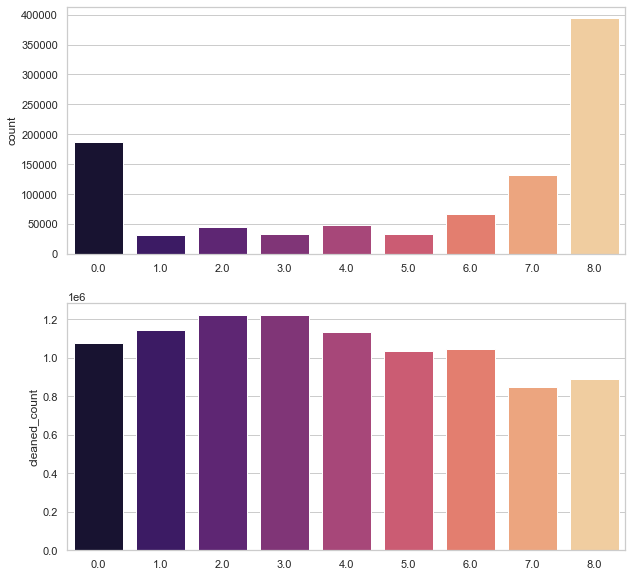

In [9]:
f, ax = plt.subplots(2,1, figsize=(10, 10))
tripweather["mean_total_cloud_cover_r"] = tripweather["mean_total_cloud_cover"].round(0)
y = tripweather.groupby(['mean_total_cloud_cover_r']).size().to_frame("count")
coverageperc = (weather["mean_total_cloud_cover"].round(0).value_counts()/weather["mean_total_cloud_cover"].size).rename("coverage %")
y = y.merge(coverageperc, left_index=True, right_index=True)
y["cleaned_count"] = y["count"] / y["coverage %"]
sns.barplot(data = y, x = y.index, y ="count", palette = "magma", ax = ax [0])
sns.barplot(data = y, x = y.index, y ="cleaned_count", palette = "magma", ax = ax[1])



In [10]:
import sys, os
import tarfile
import os
sys.path.append(os.path.abspath('..'))
%load_ext autoreload
%autoreload 2

from modules.config import *
tarfile_path = TRIPS_TARFILE_PATH
unpacked_path = UNPACKED_TRIPS_DIR_PATH

# Unpack
with tarfile.open(tarfile_path, 'r') as tar:
	tar.extractall(DATA_DIR_PATH)
# find all csv files in the unpacked directory
csv_files = []

def get_csv_files_recursively(path):
	for file in os.listdir(path):
		if os.path.isdir(os.path.join(path, file)):
			get_csv_files_recursively(os.path.join(path, file))
		elif file.endswith(".csv"):
			csv_files.append(os.path.join(path, file))

get_csv_files_recursively(unpacked_path)

csv_files[:5]

['b:\\Github desktop Repos\\aaa-2022-magma\\00_data\\leipzig\\2019\\01\\positions_nextbike_leipzig_2019_01_20.csv',
 'b:\\Github desktop Repos\\aaa-2022-magma\\00_data\\leipzig\\2019\\01\\positions_nextbike_leipzig_2019_01_21.csv',
 'b:\\Github desktop Repos\\aaa-2022-magma\\00_data\\leipzig\\2019\\01\\positions_nextbike_leipzig_2019_01_22.csv',
 'b:\\Github desktop Repos\\aaa-2022-magma\\00_data\\leipzig\\2019\\01\\positions_nextbike_leipzig_2019_01_23.csv',
 'b:\\Github desktop Repos\\aaa-2022-magma\\00_data\\leipzig\\2019\\01\\positions_nextbike_leipzig_2019_01_24.csv']

In [11]:
#read data
import shapely
flexzone = gpd.read_file(FLEXZONE_GEOJSON_PATH)
flexzone.geometry = flexzone.geometry.map(lambda polygon: shapely.ops.transform(lambda x, y: (y, x), polygon))
flexzone_loose = flexzone.dissolve()
flexzone_loose = flexzone_loose.to_crs(epsg=3763)
flexzone_loose = flexzone_loose.buffer(10000)
flexzone_loose = flexzone_loose.to_crs(epsg=4326)
flexzone_loose = gpd.GeoDataFrame(geometry=flexzone_loose)
flexzone_loose = flexzone_loose.to_crs(epsg=4326)

flexzone_size = flexzone_loose["geometry"].area
flexzone_size = flexzone_size

C:\Users\jan\AppData\Local\Temp/ipykernel_1044/2896247154.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  flexzone_size = flexzone_loose["geometry"].area


In [12]:
land_use_geo = gpd.GeoDataFrame(land_usepolys)
land_use_geo = land_use_geo.to_crs(epsg=3035)
land_use_geo = land_use_geo.to_crs(epsg=4326)
land_use_geo_reversed = land_use_geo.geometry.map(lambda multipolygon: shapely.ops.transform(lambda x, y: (y, x), multipolygon))
land_use_geo["geometry"] =  land_use_geo_reversed
land_use_geo
land_use_flexzone= gpd.overlay(land_use_geo, flexzone_loose, how='intersection')
land_use_flexzone

,country,fua_name,fua_code,code_2018,class_2018,prod_date,identifier,perimeter,area,comment,Pop2018,geometry
0,DE,Leipzig,DE008L2,11210,Discontinuous dense urban fabric (S.L. : 50% -...,2020-08,3969-DE008L2,135.628940,1080.015902,None,2,"POLYGON ((51.25573 12.37944, 51.25572 12.37906..."
1,DE,Leipzig,DE008L2,11210,Discontinuous dense urban fabric (S.L. : 50% -...,2020-08,5569-DE008L2,336.629685,6332.695900,None,92,"POLYGON ((51.32675 12.28788, 51.32606 12.28668..."
2,DE,Leipzig,DE008L2,11210,Discontinuous dense urban fabric (S.L. : 50% -...,2020-08,4352-DE008L2,3219.516723,71745.283513,None,430,"POLYGON ((51.27010 12.36293, 51.26951 12.36298..."
3,DE,Leipzig,DE008L2,12100,"Industrial, commercial, public, military and p...",2020-08,17695-DE008L2,298.224118,5453.464295,None,2,"POLYGON ((51.30811 12.43117, 51.30813 12.43117..."
4,DE,Leipzig,DE008L2,11100,Continuous urban fabric (S.L. : > 80%),2020-08,998-DE008L2,218.411702,2117.440017,None,35,"POLYGON ((51.33568 12.38648, 51.33591 12.38532..."
...,...,...,...,...,...,...,...,...,...,...,...,...
7310,DE,Leipzig,DE008L2,14200,Sports and leisure facilities,2020-08,24688-DE008L2,557.427200,15773.143591,None,1,"POLYGON ((51.39093 12.31474, 51.39170 12.31463..."
7311,DE,Leipzig,DE008L2,14200,Sports and leisure facilities,2020-08,24690-DE008L2,673.816094,26903.857103,None,1,"POLYGON ((51.39186 12.31176, 51.39179 12.31350..."
7312,DE,Leipzig,DE008L2,14200,Sports and leisure facilities,2020-08,24804-DE008L2,1221.262569,94544.717704,None,18,"POLYGON ((51.38517 12.35545, 51.38508 12.35522..."
7313,DE,Leipzig,DE008L2,14200,Sports and leisure facilities,2020-08,24830-DE008L2,1031.340083,22023.996003,None,10,"POLYGON ((51.36356 12.40752, 51.36355 12.40752..."


In [13]:
land_use_flexzone["area"] = land_use_flexzone["geometry"].area
landuseareas = land_use_flexzone.groupby(["class_2018"])["area"].sum()
landuseareas

C:\Users\jan\AppData\Local\Temp/ipykernel_1044/3815963010.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  land_use_flexzone["area"] = land_use_flexzone["geometry"].area


class_2018
Arable land (annual crops)                                                         0.006093
Construction sites                                                                 0.000023
Continuous urban fabric (S.L. : > 80%)                                             0.001845
Discontinuous dense urban fabric (S.L. : 50% -  80%)                               0.004229
Discontinuous low density urban fabric (S.L. : 10% - 30%)                          0.000099
Discontinuous medium density urban fabric (S.L. : 30% - 50%)                       0.001022
Discontinuous very low density urban fabric (S.L. : < 10%)                         0.000011
Fast transit roads and associated land                                             0.000121
Forests                                                                            0.001863
Green urban areas                                                                  0.003266
Herbaceous vegetation associations (natural grassland, moors...)     

In [14]:

land_use_flexzone["area"] = land_use_flexzone["geometry"].area
landuseratio = land_use_flexzone.groupby(["class_2018"])["area"].sum().to_frame("ratio")
landuseratio = landuseratio / landuseratio.sum()
landuseratio

C:\Users\jan\AppData\Local\Temp/ipykernel_1044/1787338608.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  land_use_flexzone["area"] = land_use_flexzone["geometry"].area


,ratio
class_2018,
Arable land (annual crops),0.194186
Construction sites,0.000730
Continuous urban fabric (S.L. : > 80%),0.058784
Discontinuous dense urban fabric (S.L. : 50% - 80%),0.134772
Discontinuous low density urban fabric (S.L. : 10% - 30%),0.003165
Discontinuous medium density urban fabric (S.L. : 30% - 50%),0.032579
Discontinuous very low density urban fabric (S.L. : < 10%),0.000365
Fast transit roads and associated land,0.003868
Forests,0.059378


c:\Users\jan\miniconda3\envs\aaMagma\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


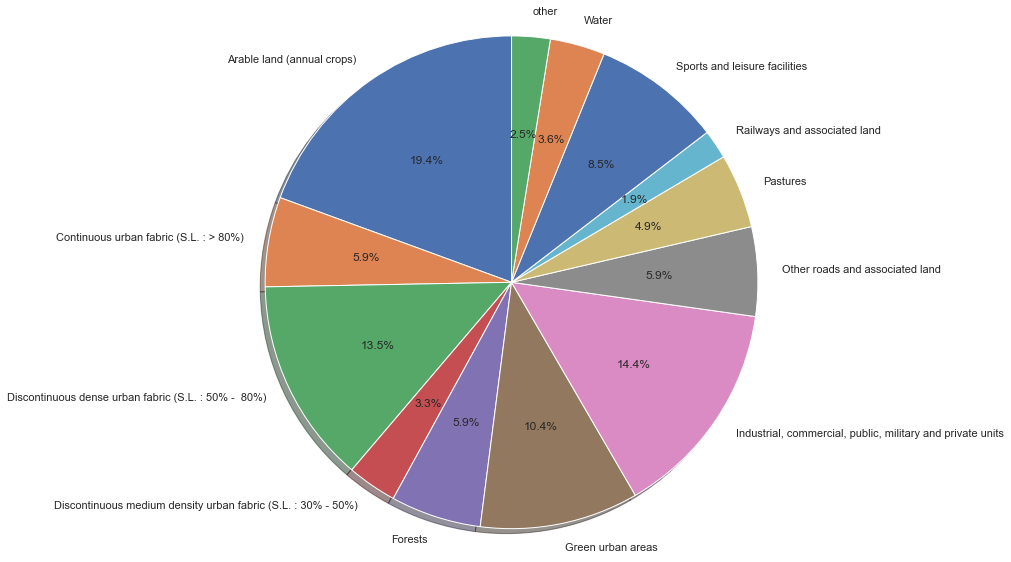

In [15]:
other = landuseratio[landuseratio["ratio"]<0.01]
othersum = other["ratio"].sum()
landuseratio_big = landuseratio[landuseratio["ratio"]>0.01]
landuseratio_big.loc["other"] = [othersum]
fig1, ax1 = plt.subplots(figsize = (15,10))

ax1.pie(landuseratio_big["ratio"], labels=landuseratio_big.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

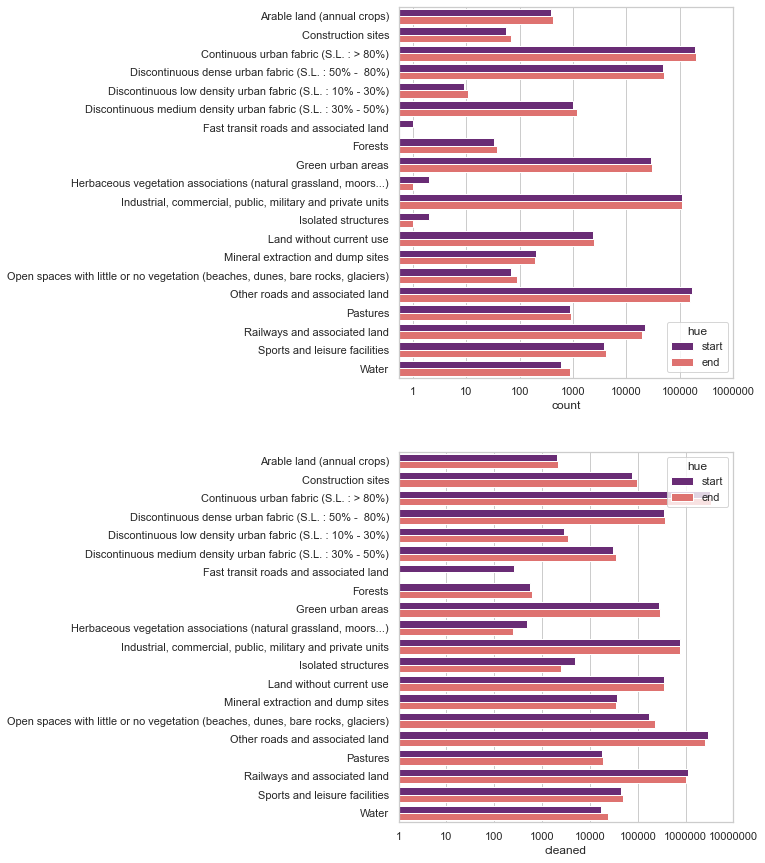

,count,hue,ratio,cleaned
Arable land (annual crops),394,start,0.194186,2.028983e+03
Arable land (annual crops),415,end,0.194186,2.137127e+03
Construction sites,56,start,0.000730,7.675753e+04
Construction sites,69,end,0.000730,9.457624e+04
Continuous urban fabric (S.L. : > 80%),189444,start,0.058784,3.222702e+06
Continuous urban fabric (S.L. : > 80%),201303,end,0.058784,3.424440e+06
Discontinuous dense urban fabric (S.L. : 50% - 80%),47297,start,0.134772,3.509416e+05
Discontinuous dense urban fabric (S.L. : 50% - 80%),50202,end,0.134772,3.724966e+05
Discontinuous low density urban fabric (S.L. : 10% - 30%),9,start,0.003165,2.844032e+03
Discontinuous low density urban fabric (S.L. : 10% - 30%),11,end,0.003165,3.476039e+03


In [16]:
sns.set(style="whitegrid")
f, ax = plt.subplots(2,1,figsize=(6, 15))
y1 = tripuse["land_use_start"].value_counts().to_frame("count")
y1["hue"] = "start"
y2 = tripuse["land_use_end"].value_counts().to_frame("count")
y2["hue"] = "end"
y_all = pd.concat([y1, y2])
y_all = y_all.merge(landuseratio, left_index= True, right_index = True)
y_all["cleaned"] = y_all["count"]/y_all["ratio"]
g = sns.barplot(data = y_all, x = "count", y = y_all.index, hue = "hue", palette= "magma", ax=ax[0] )
g.set_xscale("log")
ticks = [1, 10, 100, 1000, 10000, 100000, 1000000]
g.set_xticks(ticks)
g.set_xticklabels(ticks)
g = sns.barplot(data = y_all, x = "cleaned", y = y_all.index, hue = "hue", palette= "magma", ax=ax[1] )
g.set_xscale("log")
ticks = [1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]
g.set_xticks(ticks)
g.set_xticklabels(ticks)
plt.show()
y_all

In [17]:
poicategories = ['sustenance_poi',
       'public_transport_poi', 'education_poi', 'arts_and_culture_poi',
       'sports_poi']

In [18]:

pois9 = pois[pois["h3_res"] == 9]
naive_pois = pois9.copy()

for poi in poicategories:
    naive_pois[poi] = naive_pois[poi].clip(0,1)
naive_pois


trips_9 = trips_g[trips_g["h3_res"] == 9]

pois9["sustenance_poi"].max()

163

In [19]:

naive_pois_starts = pd.merge(trips_9, naive_pois, how='left', left_on = "start_hex_id", right_on = "hex")
naive_pois_ends = pd.merge(trips_9, naive_pois, how='left', left_on = "end_hex_id", right_on = "hex")


In [20]:
for poi in poicategories:
    naive_pois_starts[poi] = naive_pois_starts[poi] * naive_pois_starts["demand"]
    naive_pois_ends[poi] = naive_pois_ends[poi] * naive_pois_ends["demand"]

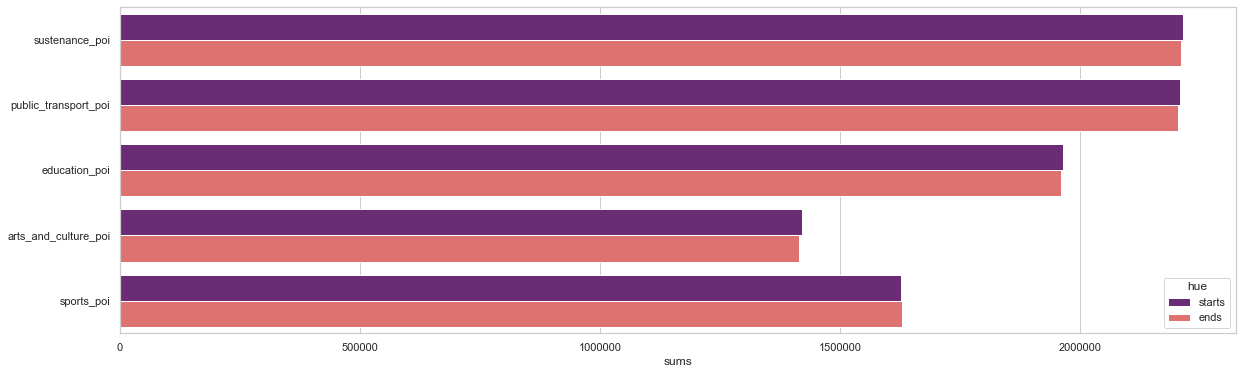

,hex,h3_res,hex_and_neighbors,sustenance_poi,public_transport_poi,education_poi,arts_and_culture_poi,sports_poi
798,891f1a10d13ffff,9,"[891f1a10d13ffff, 891f1a10dc7ffff, 891f1a10d1b...",0,3,0,0,0
799,891f1a10d8fffff,9,"[891f1a10d13ffff, 891f1a10dbbffff, 891f1a10d87...",0,3,0,0,0
800,891f1a10da7ffff,9,"[891f1a10da3ffff, 891f1a10da7ffff, 891f1a172d3...",0,1,0,0,0
801,891f1a10dabffff,9,"[891f1a10da3ffff, 891f1a10dbbffff, 891f1a10d33...",0,2,0,0,0
802,891f1a12d27ffff,9,"[891f1a12d2fffff, 891f1a12d37ffff, 891f1a12d27...",0,6,0,0,0
...,...,...,...,...,...,...,...,...
2183,891f1abb663ffff,9,"[891f1abb66bffff, 891f1abb66fffff, 891f1abb67b...",0,2,0,0,0
2184,891f1abb677ffff,9,"[891f1abb63bffff, 891f1abb62bffff, 891f1abb667...",1,9,0,0,0
2185,891f1abb68fffff,9,"[891f1abb68bffff, 891f1abb613ffff, 891f1abb617...",1,2,0,0,0
2186,891f1abb6a7ffff,9,"[891f1abb6afffff, 891f1abb6a3ffff, 891f1abb0d3...",1,2,0,0,0


In [21]:
startssum = [
    naive_pois_starts.sustenance_poi.sum(),
    naive_pois_starts.public_transport_poi.sum(),
    naive_pois_starts.education_poi.sum(),
    naive_pois_starts.arts_and_culture_poi.sum(),
    naive_pois_starts.sports_poi.sum(),
]
endssum = [
    naive_pois_ends.sustenance_poi.sum(),
    naive_pois_ends.public_transport_poi.sum(),
    naive_pois_ends.education_poi.sum(),
    naive_pois_ends.arts_and_culture_poi.sum(),
    naive_pois_ends.sports_poi.sum()
]

startsumdf = pd.DataFrame(index = poicategories)
endsumdf = pd.DataFrame(index = poicategories)
total = pd.DataFrame(index = ["total number of trips"])
startsumdf["sums"] = startssum
startsumdf["hue"] = "starts"
endsumdf["sums"] = endssum
endsumdf["hue"] = "ends"
total["sums"] = trips_9["demand"].sum()
total["hue2"] = "total"
sumsum = pd.concat([startsumdf, endsumdf])


f, ax = plt.subplots( figsize=(20, 6))
sns.barplot(data = sumsum, x = "sums", y = sumsum.index, palette= "magma", hue= "hue", )
plt.ticklabel_format(style='plain', axis='x')

plt.show()
pois9

In [22]:
startpois9 = pd.merge(trips_9, pois9, how='left', left_on = "start_hex_id", right_on = "hex")
endpois9 = pd.merge(trips_9, pois9, how='left', left_on = "end_hex_id", right_on = "hex")
trippois9 = pd.merge(startpois9, pois9, how='left', left_on = "end_hex_id", right_on = "hex")

,datetime_start_floored,start_hex_id,end_hex_id,demand,h3_res_x,time_interval_length,hex,h3_res_y,hex_and_neighbors,sustenance_poi,public_transport_poi,education_poi,arts_and_culture_poi,sports_poi
0,2019-01-20,891f1a1641bffff,891f1a8d9a3ffff,1,9,1,891f1a1641bffff,9.0,"[891f1a164c7ffff, 891f1a16403ffff, 891f1a16457...",2.0,0.0,0.0,0.0,0.0
1,2019-01-20,891f1a1643bffff,891f1a8c82fffff,2,9,1,891f1a1643bffff,9.0,"[891f1a16433ffff, 891f1a16477ffff, 891f1a16423...",50.0,16.0,6.0,2.0,0.0
2,2019-01-20,891f1a16447ffff,891f1a8d9afffff,1,9,1,891f1a16447ffff,9.0,"[891f1a16473ffff, 891f1a16457ffff, 891f1a16443...",0.0,4.0,2.0,0.0,0.0
3,2019-01-20,891f1a16467ffff,891f1a8d92bffff,1,9,1,891f1a16467ffff,9.0,"[891f1a1609bffff, 891f1a16093ffff, 891f1a16463...",35.0,13.0,7.0,1.0,1.0
4,2019-01-20,891f1a16473ffff,891f1a164abffff,1,9,1,891f1a16473ffff,9.0,"[891f1a16477ffff, 891f1a16463ffff, 891f1a16473...",2.0,8.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2092109,2019-12-30,891f1abb267ffff,891f1abb27bffff,2,9,24,891f1abb267ffff,9.0,"[891f1abb277ffff, 891f1ab949bffff, 891f1ab9493...",2.0,11.0,0.0,0.0,0.0
2092110,2019-12-30,891f1abb27bffff,891f1abb243ffff,1,9,24,891f1abb27bffff,9.0,"[891f1a8c9b7ffff, 891f1abb26bffff, 891f1abb273...",8.0,15.0,1.0,0.0,0.0
2092111,2019-12-30,891f1abb63bffff,891f1a8cda7ffff,1,9,24,891f1abb63bffff,9.0,"[891f1abb63bffff, 891f1abb62bffff, 891f1abb623...",2.0,14.0,0.0,0.0,0.0
2092112,2019-12-30,891f1abb63bffff,891f1ab968bffff,1,9,24,891f1abb63bffff,9.0,"[891f1abb63bffff, 891f1abb62bffff, 891f1abb623...",2.0,14.0,0.0,0.0,0.0


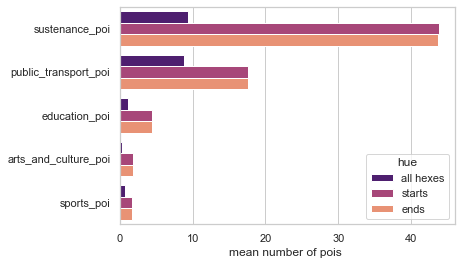

In [23]:

meanhex = pd.DataFrame(index=poicategories, columns = ["mean", "hue"])
for poi in poicategories:
    meanhex["mean"][meanhex.index == poi] = pois9[poi].mean()
meanhex["hue"] = "all hexes"

meanstarts = pd.DataFrame(index=poicategories, columns = ["mean", "hue"])
for poi in poicategories:
    meanstarts["mean"][meanstarts.index == poi] = startpois9[poi].mean()
meanstarts["hue"] = "starts"


meanends = pd.DataFrame(index=poicategories, columns = ["mean", "hue"])
for poi in poicategories:
    meanends["mean"][meanhex.index == poi] = endpois9[poi].mean()
meanends["hue"] = "ends"

all_means = pd.concat([meanhex, meanstarts, meanends])
ax = sns.barplot(data = all_means, x = "mean", y = all_means.index, hue = "hue", palette= "magma" )
ax.set_xlabel("mean number of pois ")
startpois9

In [24]:
for poi in poicategories:
    trippois9[poi + "_diff"] = abs(trippois9[poi + "_x"] - trippois9[poi + "_y"])


poidiffs = pd.DataFrame(index = poicategories, columns = ["mean","amount_with_diff"])
sustenancetrip = trippois9[trippois9.sustenance_poi_diff != 0]
poidiffs["mean"] [poidiffs.index == "sustenance_poi"] = sustenancetrip.sustenance_poi_diff.mean()
poidiffs["amount_with_diff"] [poidiffs.index == "sustenance_poi"] = sustenancetrip.demand.sum()
publictransporttrip = trippois9[trippois9.public_transport_poi_diff != 0]
poidiffs["mean"] [poidiffs.index == "public_transport_poi"] = publictransporttrip.public_transport_poi_diff.mean()
poidiffs["amount_with_diff"] [poidiffs.index == "public_transport_poi"] = publictransporttrip.demand.sum()
educationtrip = trippois9[trippois9.education_poi_diff != 0]
poidiffs["mean"] [poidiffs.index == "education_poi"] = educationtrip.education_poi_diff.mean()
poidiffs["amount_with_diff"] [poidiffs.index == "education_poi"] = educationtrip.demand.sum()
artsandculturetrip = trippois9[trippois9.arts_and_culture_poi_diff != 0]
poidiffs["mean"] [poidiffs.index == "arts_and_culture_poi"] = artsandculturetrip.arts_and_culture_poi_diff.mean()
poidiffs["amount_with_diff"] [poidiffs.index == "arts_and_culture_poi"] = artsandculturetrip.demand.sum()
sporttrip = trippois9[trippois9.sports_poi_diff != 0]
poidiffs["mean"] [poidiffs.index == "sports_poi"] = sporttrip.sports_poi_diff.mean()
poidiffs["amount_with_diff"] [poidiffs.index == "sports_poi"] = sporttrip.demand.sum()



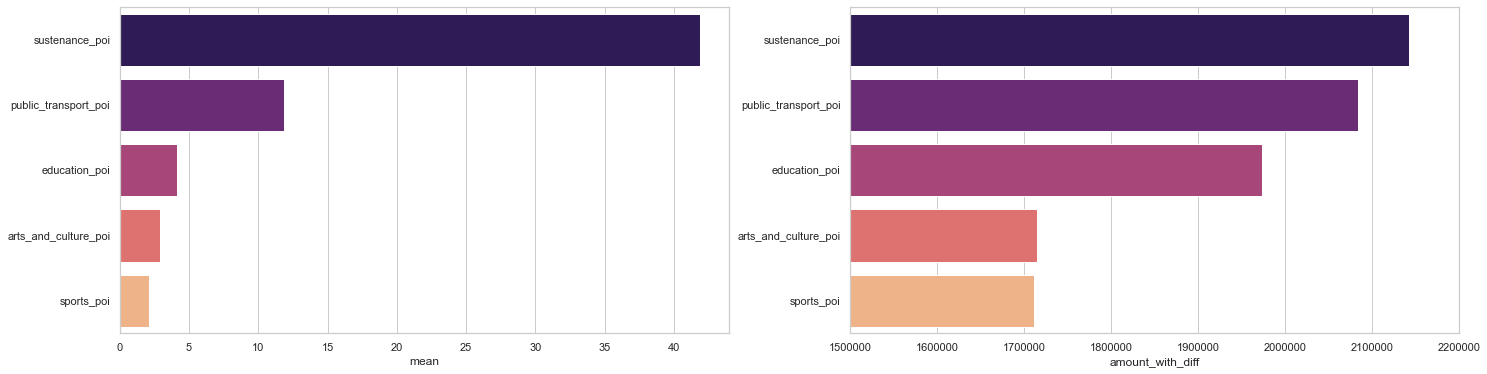

In [25]:
f, ax = plt.subplots(1,2, figsize=(24, 6))
sns.barplot(data = poidiffs, x = "mean", y = poidiffs.index, ax=ax[0], palette = "magma")
sns.barplot(data = poidiffs, x = "amount_with_diff", y = poidiffs.index, ax = ax[1], palette = "magma")
plt.xlim(1500000, 2200000)
plt.ticklabel_format(style='plain', axis='x')



In [26]:
poicorrs = pd.DataFrame(index = poicategories, columns = ["x", "y", "diff"])
for poi in poicategories:
    poicorrs["x"][poicorrs.index == poi] =  trippois9.demand.corr(trippois9[poi + "_x"])
    poicorrs["y"][poicorrs.index == poi] = trippois9.demand.corr(trippois9[poi + "_y"])
    poicorrs["diff"][poicorrs.index == poi] = trippois9.demand.corr(trippois9[poi + "_diff"])

poicorrs

,x,y,diff
sustenance_poi,0.05235,0.043933,0.002902
public_transport_poi,0.033115,0.023755,0.000708
education_poi,0.039693,0.035676,-0.018029
arts_and_culture_poi,0.057931,0.051538,0.003934
sports_poi,0.029202,0.029195,-0.007238


In [35]:
tripsbytime = trips.sort_values(by=["datetime_end"])
triplasts = tripsbytime.groupby("b_number").last()

triplasts
trips_g

,datetime_start_floored,start_hex_id,end_hex_id,demand,h3_res,time_interval_length
0,2019-01-20,871f1a164ffffff,871f1a164ffffff,1,7,1
1,2019-01-20,871f1a164ffffff,871f1a8c8ffffff,2,7,1
2,2019-01-20,871f1a164ffffff,871f1a8cbffffff,1,7,1
3,2019-01-20,871f1a164ffffff,871f1a8d9ffffff,3,7,1
4,2019-01-20,871f1a165ffffff,871f1ab96ffffff,1,7,1
...,...,...,...,...,...,...
494293,2019-12-30,891f1abb267ffff,891f1abb27bffff,2,9,24
494294,2019-12-30,891f1abb27bffff,891f1abb243ffff,1,9,24
494295,2019-12-30,891f1abb63bffff,891f1a8cda7ffff,1,9,24
494296,2019-12-30,891f1abb63bffff,891f1ab968bffff,1,9,24
